In [7]:
%matplotlib inline
from matplotlib import pyplot as plt 
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [3]:
class_name = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [8]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4915, 0.4823, 0.4468),
            (0.2470, 0.2435, 0.2616)
        )
    ])
)

Extracting ../data-unversioned/p1ch6/cifar-10-python.tar.gz to ../data-unversioned/p1ch6/


In [6]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4915, 0.4823, 0.4468),
            (0.2470, 0.2435, 0.2616)
        )
    ])
)

In [9]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
        for img, label in cifar10
        if label in [0, 2]]

cifar2_val = [(img, label_map[label])
        for img, label in cifar10_val
        if label in [0, 2]]

In [10]:
connected_model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2)
)

In [12]:
numel_list = [p.numel() # Returns the total number of elements in the input tensor.
            for p in connected_model.parameters()
            if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [16]:
first_model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

In [17]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [18]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [48]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [49]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [50]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

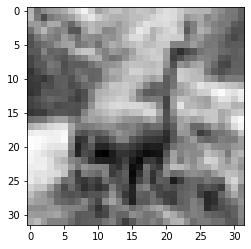

In [37]:
# Returns the mean value of all elements in the input tensor.
plt.imshow(img.mean(0), cmap='gray')
plt.show()

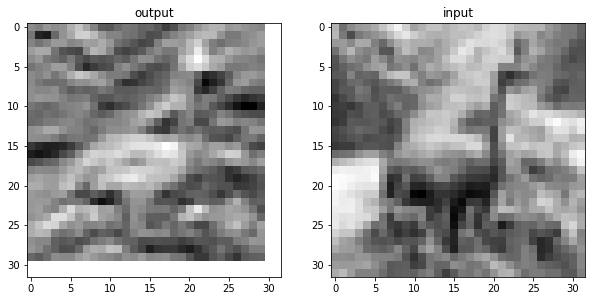

In [45]:
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
# con2d之后的图像，w，h变小了
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.savefig('Ch8_F2_PyTorch.png')
plt.show()


In [53]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1) # with padding
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [54]:
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0) # Fills self tensor with the specified value.

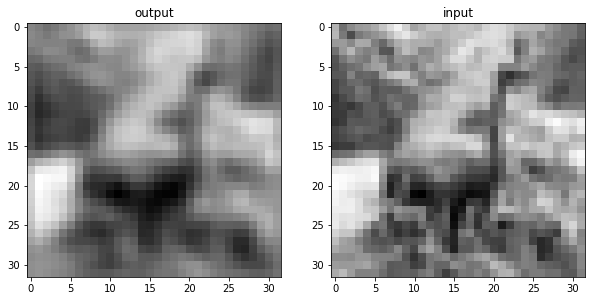

In [55]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.savefig('Ch8_F4_PyTorch.png')
plt.show()

In [56]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([
        [-1.0, 0.0, 1.0],
        [-1.0, 0.0, 1.0],
        [-1.0, 0.0, 1.0]
    ])
    conv.bias.zero_()

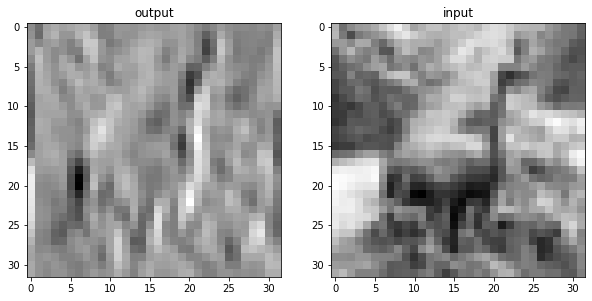

In [60]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex= ax1, sharey = ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.savefig('Ch8_F5_PyTorch.png')
plt.show()

In [61]:
# downsampling 
pool = nn.MaxPool2d(2) # half of img
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [62]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
)

In [64]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

In [65]:
model

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Tanh()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Tanh()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Linear(in_features=512, out_features=32, bias=True)
  (7): Tanh()
  (8): Linear(in_features=32, out_features=2, bias=True)
)

In [66]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [68]:
model(img.unsqueeze(0))

RuntimeError: size mismatch, m1: [64 x 8], m2: [512 x 32] at /opt/conda/conda-bld/pytorch_1579040055865/work/aten/src/TH/generic/THTensorMath.cpp:136

In [69]:
class Net(nn.Module):
    # 初始化模型
    def __init__(self):
        super().__init__() # 使用父类所有方法
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [70]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])